
# 🧪 **Optuna Results Analysis - Intermediate Tests with GLM, GAM and SR**  



### 📚 **Importing functions from Optuna**

In [42]:
import optuna
#from optuna.visualization import plot_contour
#from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_timeline

import plotly.express as px

### **Generalized Linear Model (GLM)**

In [2]:
study_name = "optimization_clusters_glm_teste1751900564.8571913"
storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"

study_glm = optuna.load_study(study_name=study_name, storage=storage_url)


##### **Best trial**

In [3]:
print(f"The best trial had RMSE equal to {study_glm.best_value:.2f}")

The best trial had RMSE equal to 13.84


In [4]:
print(f"The best params were: {study_glm.best_params}")

The best params were: {'clusterer': 'kmeans', 'n_clusters': 10, 'distribution': 'gaussian', 'link_gaussian': 'identity'}


##### **Optimization history**

This plot shows the study optimization history, by showing the objective value for each Optuna trial.

In [56]:
import pandas as pd

df = study_glm.trials_dataframe()
df_filter = df[(df["state"] != "PRUNED") & (df["value"] <= 10e1)]

fig = px.scatter(df_filter, 
                 x="number", 
                 y="value", 
                 symbol="params_clusterer",
                 color="params_n_clusters")
fig.update_layout(
    width=800,  # Largura em pixels
    height=500
)
fig.show()
df_filter

,number,value,datetime_start,datetime_complete,duration,params_bandwidth,params_bisecting_strategy,params_clusterer,params_damping,params_distribution,params_link_gaussian,params_link_inverse_gaussian,params_n_clusters,params_n_clusters_bkmeans,state
6,6,14.782951,2025-07-07 12:34:16.158908,2025-07-07 12:34:33.276129,0 days 00:00:17.117221,NaN,NaN,kmeans,NaN,gaussian,log,NaN,6.0,NaN,COMPLETE
13,13,16.004627,2025-07-07 12:37:15.105854,2025-07-07 12:37:30.963141,0 days 00:00:15.857287,NaN,NaN,kmeans,NaN,gaussian,log,NaN,5.0,NaN,COMPLETE
16,16,14.473185,2025-07-07 12:38:26.460289,2025-07-07 12:38:31.034507,0 days 00:00:04.574218,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,5.0,NaN,COMPLETE
17,17,14.284180,2025-07-07 12:38:31.074827,2025-07-07 12:38:36.163832,0 days 00:00:05.089005,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,6.0,NaN,COMPLETE
20,20,13.957999,2025-07-07 12:39:21.058979,2025-07-07 12:39:26.572843,0 days 00:00:05.513864,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,7.0,NaN,COMPLETE
21,21,13.957999,2025-07-07 12:39:26.620616,2025-07-07 12:39:32.352095,0 days 00:00:05.731479,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,7.0,NaN,COMPLETE
22,22,13.957999,2025-07-07 12:39:32.390659,2025-07-07 12:39:38.175450,0 days 00:00:05.784791,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,7.0,NaN,COMPLETE
23,23,13.957999,2025-07-07 12:39:38.207959,2025-07-07 12:39:43.997435,0 days 00:00:05.789476,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,7.0,NaN,COMPLETE
24,24,17.282648,2025-07-07 12:39:44.019922,2025-07-07 12:39:50.493664,0 days 00:00:06.473742,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,8.0,NaN,COMPLETE
26,26,17.282648,2025-07-07 12:39:50.767634,2025-07-07 12:39:57.197064,0 days 00:00:06.429430,NaN,NaN,kmeans,NaN,gaussian,identity,NaN,8.0,NaN,COMPLETE


We can't see anything with this! The graph is probably distorted by the outlier. To avoid this, we can manually filter the test results to avoid None (Optuna prune) and outliers.

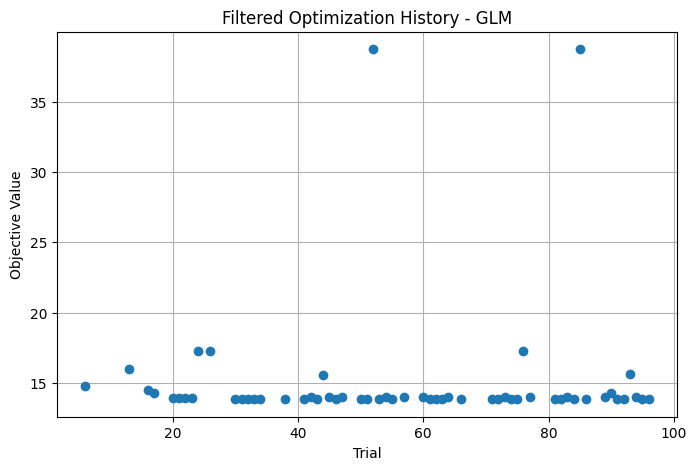

In [6]:
import matplotlib.pyplot as plt
trials = [t for t in study_glm.trials if t.value is not None and t.value < 100]

plt.figure(figsize=(8, 5))
plt.plot([t.number for t in trials], [t.value for t in trials], "o")
plt.title("Filtered Optimization History - GLM")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()

Now we can clearly see that most attempts are still close to 15, which makes sense considering that the best attempt reached a value of 13.83.

##### **Contour plot !**

Plot the parameter relationship between two features. In our case, number of clusters (n_clusters) and type of clusterer used (clusterer).

In [7]:
plot_contour(study_glm, params=["n_clusters", "clusterer"])

From this graph it is possible to see that the tests were dominated by the K-means clusterer and a greater number of clusters, in general, presented better results.

##### **Hyperparameter Importances**

Plot hyperparameter importances based on the Optuna attempts.

In [8]:
plot_param_importances(study_glm)

Distribution seems like the most important feature for Optuna Optimization.

##### **Timeline plot**

Plot the timeline of a study, indicating complete and pruned trials.

In [9]:
plot_timeline(study_glm)


Many prunned trials!

### **Generalized Additive Model (GAM)**

In [10]:
study_name = "optimization_clusters_gam_teste08_07_2025_10_22_58"
storage_url = "sqlite:///../Optuna_files/optimization_gam.db"

study_gam = optuna.load_study(study_name=study_name, storage=storage_url)

##### **Best trial**

In [11]:
print(f"The best trial had RMSE equal to {study_gam.best_value:.2f}")

The best trial had RMSE equal to 12.01


In [12]:
print(f"The best params were {study_gam.best_params}")

The best params were {'clusterer': 'bisecting_kmeans', 'n_clusters_bkmeans': 13, 'bisecting_strategy': 'largest_cluster', 'distribution': 'normal', 'link_gaussian': 'identity', 'lam': 3.0146186479252566, 'n_splines': 16}


##### **Optimization history**

In [13]:
plot_optimization_history(study_gam)

We can´t see anything with this (again)! So let´s see without the outliers.

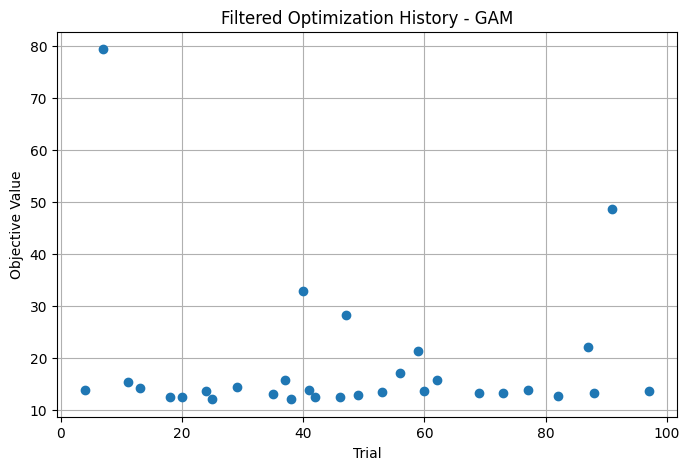

In [14]:
import matplotlib.pyplot as plt
trials = [t for t in study_gam.trials if t.value is not None and t.value < 100]

# Plot manual
plt.figure(figsize=(8, 5))
plt.plot([t.number for t in trials], [t.value for t in trials], "o")
plt.title("Filtered Optimization History - GAM")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()

The behavior is very similar to GLM. But two differences can be noticed: the values ​​are smaller and there are fewer attempts.

##### **Contour plot**

In [15]:
plot_contour(study_gam, params=["n_clusters", "clusterer"]);

##### **Hyperparameter Importances**

In [16]:
plot_param_importances(study_gam)

In the case of GAM, the most important hyperparameter was the number of splines per feature.

##### **Timeline plot**

In [17]:
plot_timeline(study_gam)

The time was longer compared with GLM, but it appears there were fewer pruned trials.

### **Symbolic Regression (SR)**

In [18]:
study_name = "optimization_clusters_gam_teste15_07_2025_15_40_36" 
# The first version of script_sr.py defined the name with "gam" word. This was fixed in the new version!
from pathlib import Path

storage_url = f"sqlite:///../Optuna_files/optimization_sr.db"


study_sr = optuna.load_study(study_name=study_name, storage=storage_url)

#### **Best trial**

In [19]:
print(f"The best trial had RMSE equal to {study_sr.best_value:.2f}")

The best trial had RMSE equal to 17.49


In [20]:
print(f"The best params were: {study_sr.best_params}")

The best params were: {'clusterer': 'bisecting_kmeans', 'n_clusters_bkmeans': 17, 'bisecting_strategy': 'largest_cluster', 'n_iterations': 23, 'maxsize': 29, 'maxdepth': 14, 'n_binary_operators': 9, 'binary_operators_0': '*', 'binary_operators_1': '^', 'binary_operators_2': '*', 'binary_operators_3': '*', 'binary_operators_4': '+', 'binary_operators_5': '*', 'binary_operators_6': '+', 'binary_operators_7': '+', 'binary_operators_8': '-', 'n_unary_operators': 19, 'unary_operators_0': 'sin', 'unary_operators_1': 'sin', 'unary_operators_2': 'neg', 'unary_operators_3': 'tan', 'unary_operators_4': 'cube', 'unary_operators_5': 'cos', 'unary_operators_6': 'sqrt', 'unary_operators_7': 'inv', 'unary_operators_8': 'sin', 'unary_operators_9': 'tan', 'unary_operators_10': 'abs', 'unary_operators_11': 'exp', 'unary_operators_12': 'exp', 'unary_operators_13': 'log', 'unary_operators_14': 'log', 'unary_operators_15': 'sqrt', 'unary_operators_16': 'abs', 'unary_operators_17': 'neg', 'unary_operators_1

#### **Optimization story**

In [21]:
plot_optimization_history(study_sr)

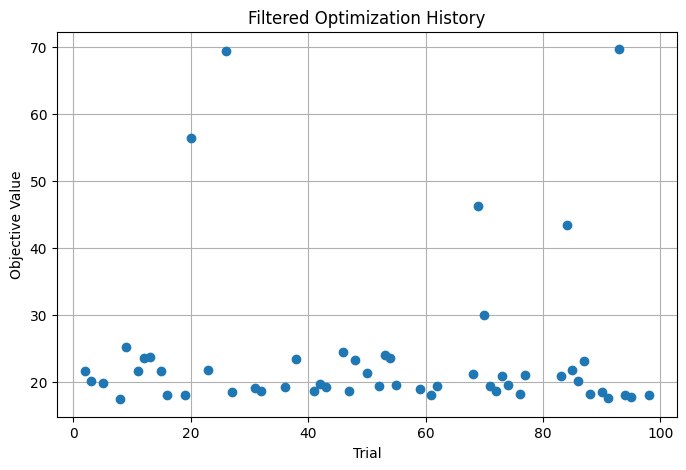

In [22]:
import matplotlib.pyplot as plt
trials = [t for t in study_sr.trials if t.value is not None and t.value < 100]

# Plot manual
plt.figure(figsize=(8, 5))
plt.plot([t.number for t in trials], [t.value for t in trials], "o")
plt.title("Filtered Optimization History")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()

#### **Contour Plot**

In [23]:
plot_contour(study_gam, params=["n_clusters", "clusterer"])

### 🗃️ **References!**

[1] Quick Visualization for Hyperparameter Optimization Analysis — Optuna 4.4.0 documentation. Available: <https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html>. Acess in: 9 jul. 2025.

